# Basic demonstration 

This notebook it intended to demonstrate some of the basic concepts in the new version of of the rompy code

- Separation of 'runtime' from 'config' - more on this later
- Modular
    - There are a number of core objects 
- Pydantic throughout
    - Strong typing
    - Clearly defined APIs
    - Built in validators
- Declaritive
    - The entire configuration to run the model is passed at intantiation. 
    - The core wrapper is a pycallable, making it play nicely with downstream workflow packages (e.g. airflow)
    - Can still be run proceduraly. 
- Separation of intake components. 
    - Common filters now available as a separate import. 
    - Data is provdided to the wrapper as large lazy datasets, and data selection is done based on runtime period and grid spatial extents
    - Substantially reduced the fricton to hook up a different dataset
    - Filters are still available to use in intake drivers where appropriate (e.g. where constructing nowcasts from many forecasts becomes memory prohibitive to do lazily)

In [1]:
# Set up notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import some core objects
from rompy.swan import SwanConfig, SwanDataGrid, SwanGrid
from rompy.core import TimeRange, ModelRun, BaseConfig, BaseGrid, RegularGrid, DatasetXarray
from rompy.swan.data import SwanDataGrid
import xarray as xr
import numpy as np
import tempfile
import os
import pandas as pd
from datetime import datetime
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [3]:
# The highest level object is the ModelRun which is a generic class to run any model type. 
# Lets start by looking at the ModelRun api

ModelRun??

Init signature:
ModelRun(
    *,
    run_id: str = 'run_id',
    period: rompy.core.time.TimeRange = TimeRange(start=datetime.datetime(2020, 2, 21, 4, 0), end=datetime.datetime(2020, 2, 24, 4, 0), duration=datetime.timedelta(days=3), interval=datetime.timedelta(seconds=900), include_end=True),
    output_dir: str = 'simulations',
    config: rompy.core.config.BaseConfig = BaseConfig(model_type='base', template='/source/rompy/rompy/templates/base', checkout='main'),
) -> None
Source:        
class ModelRun(RompyBaseModel):
    """A base class for all models"""

    run_id: str = Field("run_id", description="The run id")
    period: TimeRange = Field(
        TimeRange(
            start=datetime(2020, 2, 21, 4),
            end=datetime(2020, 2, 24, 4),
            interval="15M",
        ),
        description="The time period to run the model",
    )
    output_dir: str = Field("simulations", description="The output directory")
    config: BaseConfig = Field(
        BaseConfig(), des

In [4]:
# So we can see that the ModelRun takes an id, a time run period, an output directort and a model configuration. 
 # TimeRange is a simple class that calculates run dates based on combinations of start, end, and interval.

TimeRange??

Init signature:
TimeRange(
    *,
    start: Optional[datetime.datetime] = None,
    end: Optional[datetime.datetime] = None,
    duration: Union[str, datetime.timedelta, NoneType] = None,
    interval: Union[str, datetime.timedelta, NoneType] = '1h',
    include_end: bool = True,
) -> None
Source:        
class TimeRange(BaseModel):
    """
    A time range object

    Examples
    --------
    >>> from rompy import TimeRange
    >>> tr = TimeRange(start="2020-01-01", end="2020-01-02")
    >>> tr
    TimeRange(start=datetime.datetime(2020, 1, 1, 0, 0), end=datetime.datetime(2020, 1, 2, 0, 0), duration=None, interval=None, include_end=True)
    >>> tr = TimeRange(start="2020-01-01", duration="1d")
    >>> tr
    TimeRange(start=datetime.datetime(2020, 1, 1, 0, 0), end=datetime.datetime(2020, 1, 2, 0, 0), duration=timedelta(days=1), interval=None, include_end=True)
    >>> tr = TimeRange(start="2020-01-01", duration="1d", interval="1h")
    >>> tr
    TimeRange(start=datetime.datetime(2

In [5]:
# The model configuration is a generic object that can be used to configure any model type.

# The simplest model configuration is the BaseConfig on which all model configurations are based.

BaseConfig??

Init signature:
BaseConfig(
    *,
    model_type: Literal['base'] = 'base',
    template: Optional[str] = '/source/rompy/rompy/templates/base',
    checkout: Optional[str] = 'main',
    **extra_data: Any,
) -> None
Source:        
class BaseConfig(RompyBaseModel):
    """A base class for all templates"""

    model_type: Literal["base"] = "base"
    template: Optional[str] = Field(
        description="The path to the model template",
        default=DEFAULT_TEMPLATE,
    )
    checkout: Optional[str] = Field(
        description="The git branch to use if the template is a git repo",
        default="main",
    )

    class Config:
        extra = "allow"
File:           /source/rompy/rompy/core/config.py
Type:           ModelMetaclass
Subclasses:     SwanConfig, SwanConfigPydantic

In [6]:
# So a configuraton is just a dictionary of key value pairs coupled with a path to a template to used to render these arguments (more on this later). 
# If the path to the template is a local file, this is used directly, if it points to a remote repository, that will be cloned locally using the 
# cookiecutter mechanics and the path to the local copy will be used.

In [7]:
# Before we start to look at the derived swan classes, lets look at a couple of other important base classes. 
# First, a generic model grid
BaseGrid??

Init signature:
BaseGrid(
    *,
    x: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    y: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    grid_type: Literal['base'] = 'base',
) -> None
Source:        
class BaseGrid(RompyBaseModel):
    """
    An object which provides an abstract representation of a grid in some geographic space

    This is the base class for all Grid objects. The minimum representation of a grid are two
    NumPy array's representing the vertices or nodes of some structured or unstructured grid,
    its bounding box and a boundary polygon. No knowledge of the grid connectivity is expected.
    """

    x: Optional[NDArray] = Field(description="A 1D array of x coordinates")
    y: Optional[NDArray] = Field(description="A 1D array of y coordinates")
    grid_type: Literal["base"] = "base"

    @property
    def minx(self) -> float:
        return np.nanmin(self.x)

    @property
    def maxx(self) -> float:
        return np.nanmax(self.x)



In [8]:
# Regular grids inherit from this base grid class, but can be defined by some simple paramaters due to their regular nature.
RegularGrid??

Init signature:
RegularGrid(
    *,
    x: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    y: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    grid_type: Literal['regular'] = 'regular',
    x0: Optional[float] = None,
    y0: Optional[float] = None,
    rot: Optional[float] = 0.0,
    dx: Optional[float] = None,
    dy: Optional[float] = None,
    nx: Optional[int] = None,
    ny: Optional[int] = None,
) -> None
Source:        
class RegularGrid(BaseGrid):
    """
    An object which provides an abstract representation of a regular grid in
    some geographic space
    """

    grid_type: Literal["regular"] = Field(
        "regular", description="Type of grid, must be 'regular'"
    )
    x0: Optional[float] = Field(
        None, description="X coordinate of the grid origin")
    y0: Optional[float] = Field(
        None, description="Y coordinate of the grid origin")
    rot: Optional[float] = Field(
        0.0, description="Rotation angle of the grid in de

In [9]:
# Now lets look at some on the the swan specific classes that inherit from these base classes
from rompy.swan import SwanDataGrid, SwanGrid, SwanConfig

In [10]:
SwanGrid??


Init signature:
SwanGrid(
    *,
    x: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    y: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    grid_type: Literal['REG'] = 'REG',
    x0: Optional[float] = None,
    y0: Optional[float] = None,
    rot: Optional[float] = 0.0,
    dx: Optional[float] = None,
    dy: Optional[float] = None,
    nx: Optional[int] = None,
    ny: Optional[int] = None,
    exc: Optional[float] = None,
    gridfile: Optional[rompy.swan.grid.ConstrainedStrValue] = None,
) -> None
Source:        
class SwanGrid(RegularGrid):
    """
    An object which provides an abstract representation of a regular SWAN
    grid in some geographic space
    """

    grid_type: Literal["REG"] = Field(
        "REG", description="Type of grid (REG=regular, CURV=curvilinear)"
    )
    exc: Optional[float] = Field(None, description="Missing value")
    gridfile: Optional[str] = Field(
        None, description="Name of grid file to load", max_length=100
    )

In [11]:
SwanConfig??

Init signature:
SwanConfig(
    *,
    model_type: Literal['swan'] = 'swan',
    template: str = '/source/rompy/rompy/templates/swan',
    checkout: Optional[str] = 'main',
    grid: rompy.swan.grid.SwanGrid,
    spectral_resolution: rompy.swan.config.SwanSpectrum = SwanSpectrum(fmin=0.0464, fmax=1.0, nfreqs=31, ndirs=36),
    forcing: rompy.swan.config.ForcingData = ForcingData(bottom=None, wind=None, current=None, boundary=None),
    physics: rompy.swan.config.SwanPhysics = SwanPhysics(friction='MAD', friction_coeff=0.1),
    outputs: rompy.swan.config.Outputs = Outputs(grid=GridOutput(period=None, variables=['DEPTH', 'UBOT', 'HSIGN', 'HSWELL', 'DIR', 'TPS', 'TM01', 'WIND']), spec=SpecOutput(period=None, locations=OutputLocs
)),
    spectra_file: str = 'boundary.spec',
    **extra_data: Any,
) -> None
Source:        
class SwanConfig(BaseConfig):
    """SWAN configuration"""

    grid: SwanGrid = Field(description="The model grid for the SWAN run")
    model_type: Literal["swan"] = F

In [12]:
# So we can see that the SwanConfig is a BaseConfig with some additional arguments.
# These arguments are broken up into several compoents, lets examine these individually.
from rompy.swan.config import SwanSpectrum, ForcingData, SwanPhysics, Outputs, SwanDataGrid

In [13]:
SwanSpectrum??

Init signature:
SwanSpectrum(
    *,
    fmin: float = 0.0464,
    fmax: float = 1.0,
    nfreqs: int = 31,
    ndirs: int = 36,
) -> None
Source:        
class SwanSpectrum(Spectrum):
    """SWAN Spectrum"""

    @property
    def cmd(self):
        return f"CIRCLE {self.ndirs} {self.fmin} {self.fmax} {self.nfreqs}"
File:           /source/rompy/rompy/swan/config.py
Type:           ModelMetaclass
Subclasses:     

In [14]:
SwanDataGrid??

Init signature:
SwanDataGrid(
    *,
    id: str,
    dataset: rompy.core.data.DatasetXarray | rompy.core.data.DatasetIntake,
    filter: Optional[rompy.core.filters.Filter] = Filter(sort={}, subset={}, crop={}, timenorm={}, rename={}, derived={}),
    variables: Optional[list[str]] = [],
    latname: Optional[str] = 'latitude',
    lonname: Optional[str] = 'longitude',
    timename: Optional[str] = 'time',
    z1: str = None,
    z2: str = None,
    var: str = 'WIND',
) -> None
Source:        
class SwanDataGrid(DataGrid):
    """This class is used to write SWAN data from a dataset."""

    z1: str = Field(
        description="Scaler paramater u componet of vecotr field",
        default=None,
    )
    z2: str = Field(description="v componet of vecotr field",
                    type=str, default=None)
    var: str = Field(
        description="SWAN variable name (WIND, BOTTOM, CURRENT)",
        default="WIND",
    )

    # root validator
    @root_validator
    def ensure_z1_in_da

In [15]:
SwanPhysics??

Init signature: SwanPhysics(*, friction: str = 'MAD', friction_coeff: float = 0.1) -> None
Source:        
class SwanPhysics(RompyBaseModel):
    """Container class represting configuraable SWAN physics options"""

    friction: str = Field(
        default="MAD", description="The type of friction, either 'MAD' or 'TODO'."
    )
    friction_coeff: float = Field(
        default=0.1,
        description="The coefficient of friction for the given surface and object.",
    )

    @validator("friction")
    def validate_friction(cls, v):
        if v not in ["MAD", "OTHER", "ANDANOTHER"]:
            raise ValueError(
                "friction must be one of MAD, OTHER or ANDANOTHER"
            )  # TODO Raf to add actual friction options
        return v

    @validator("friction_coeff")
    def validate_friction_coeff(cls, v):
        # TODO Raf to add sensible friction coeff range
        if float(v) > 1:
            raise ValueError("friction_coeff must be less than 1")
        if fl

In [16]:
ForcingData??

Init signature:
ForcingData(
    *,
    bottom: rompy.swan.data.SwanDataGrid | None = None,
    wind: rompy.swan.data.SwanDataGrid | None = None,
    current: rompy.swan.data.SwanDataGrid | None = None,
    boundary: rompy.swan.boundary.DataBoundary | None = None,
) -> None
Source:        
class ForcingData(RompyBaseModel):
    bottom: SwanDataGrid | None = Field(
        None, description="Bathymetry data for SWAN"
    )  # TODO Raf should probably be required?
    wind: SwanDataGrid | None = Field(
        None, description="The wind data for SWAN.")
    current: SwanDataGrid | None = Field(
        None, description="The current data for SWAN.")
    boundary: DataBoundary | None = Field(
        None, description="The boundary data for SWAN."
    )

    def get(self, grid, runtime):
        forcing = []
        boundary = []
        for source in self:
            if source[1]:
                logger.info(f"\t Processing {source[0]} forcing")
                source[1]._filter_grid(g

In [17]:
SwanGrid??

Init signature:
SwanGrid(
    *,
    x: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    y: Optional[pydantic_numpy.ndarray.PydanticNDArray] = None,
    grid_type: Literal['REG'] = 'REG',
    x0: Optional[float] = None,
    y0: Optional[float] = None,
    rot: Optional[float] = 0.0,
    dx: Optional[float] = None,
    dy: Optional[float] = None,
    nx: Optional[int] = None,
    ny: Optional[int] = None,
    exc: Optional[float] = None,
    gridfile: Optional[rompy.swan.grid.ConstrainedStrValue] = None,
) -> None
Source:        
class SwanGrid(RegularGrid):
    """
    An object which provides an abstract representation of a regular SWAN
    grid in some geographic space
    """

    grid_type: Literal["REG"] = Field(
        "REG", description="Type of grid (REG=regular, CURV=curvilinear)"
    )
    exc: Optional[float] = Field(None, description="Missing value")
    gridfile: Optional[str] = Field(
        None, description="Name of grid file to load", max_length=100
    )

(<Figure size 1000x706.373 with 1 Axes>, <GeoAxes: >)

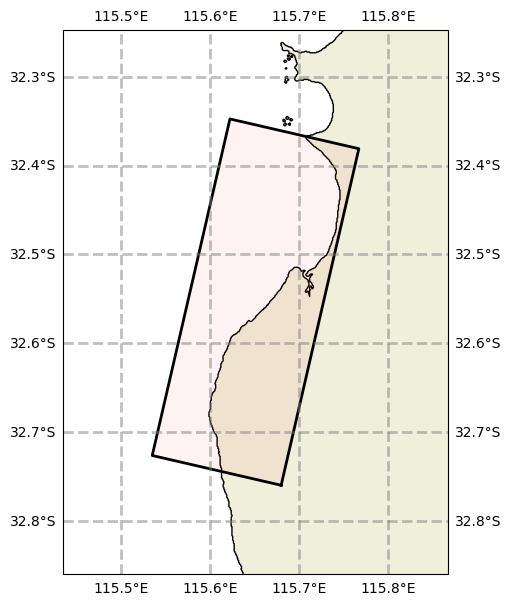

In [18]:
# Lets start by intantiaing a Swan grid

grid = SwanGrid(x0=115.68, y0=-32.76, dx=0.001, dy=0.001, nx=390, ny=150, rot=77)
grid.plot()

In [19]:
# Now lets look at how we might use that grid to define some data inputs
SwanDataGrid??

Init signature:
SwanDataGrid(
    *,
    id: str,
    dataset: rompy.core.data.DatasetXarray | rompy.core.data.DatasetIntake,
    filter: Optional[rompy.core.filters.Filter] = Filter(sort={}, subset={}, crop={}, timenorm={}, rename={}, derived={}),
    variables: Optional[list[str]] = [],
    latname: Optional[str] = 'latitude',
    lonname: Optional[str] = 'longitude',
    timename: Optional[str] = 'time',
    z1: str = None,
    z2: str = None,
    var: str = 'WIND',
) -> None
Source:        
class SwanDataGrid(DataGrid):
    """This class is used to write SWAN data from a dataset."""

    z1: str = Field(
        description="Scaler paramater u componet of vecotr field",
        default=None,
    )
    z2: str = Field(description="v componet of vecotr field",
                    type=str, default=None)
    var: str = Field(
        description="SWAN variable name (WIND, BOTTOM, CURRENT)",
        default="WIND",
    )

    # root validator
    @root_validator
    def ensure_z1_in_da

In [20]:
# Here we are creting some dummy data here to use as a bathymetry input
from rompy.swan import SwanDataGrid
os.makedirs("simulations/test_swantemplate/datasets", exist_ok=True)
datagrid = SwanGrid(x0=115.68, y0=-32.76, rot=77, nx=391, ny=151, dx=0.01, dy=0.01, exc=-99.0)

def nc_bathy(bottom=datagrid):
    # touch temp netcdf file
    tmp_path = tempfile.mkdtemp()
    source = os.path.join("simulations", "test_swantemplate", "datasets", "bathy.nc")
    bbox = bottom.bbox(buffer=1)
    lat = np.arange(bbox[1], bbox[3], bottom.dy)
    lon = np.arange(bbox[0], bbox[2], bottom.dx)
    ds = xr.Dataset(
        {
            "depth": xr.DataArray(
                np.random.rand(lat.size, lon.size),
                dims=["lat", "lon"],
                coords={"lat": lat, "lon": lon},
            ),
        }
    )
    ds.to_netcdf(source, mode="w")
    return source

# and same again for wind
def nc_data_source(wind_grid=datagrid):
    tmp_path = tempfile.mkdtemp()
    source = os.path.join("simulations", "test_swantemplate", "datasets", "wind_inputs.nc")

    bbox = wind_grid.bbox(buffer=1)
    lat = np.arange(bbox[1], bbox[3], wind_grid.dy)
    lon = np.arange(bbox[0], bbox[2], wind_grid.dx)
    time = pd.date_range("2020-2-21", periods=10)

    ds = xr.Dataset(
        {
            "u": xr.DataArray(
                np.random.rand(10, lat.size, lon.size),
                dims=["time", "lat", "lon"],
                coords={
                    "time": time,
                    "lat": lat,
                    "lon": lon,
                },
            ),
            "v": xr.DataArray(
                np.random.rand(10, lat.size, lon.size),
                dims=["time", "lat", "lon"],
                coords={
                    "time": time,
                    "lat": lat,
                    "lon": lon,
                },
            ),
        }
    )
    ds.to_netcdf(source, mode="w")
    return source

(<Figure size 1000x1415.7 with 2 Axes>, <GeoAxes: xlabel='lon', ylabel='lat'>)

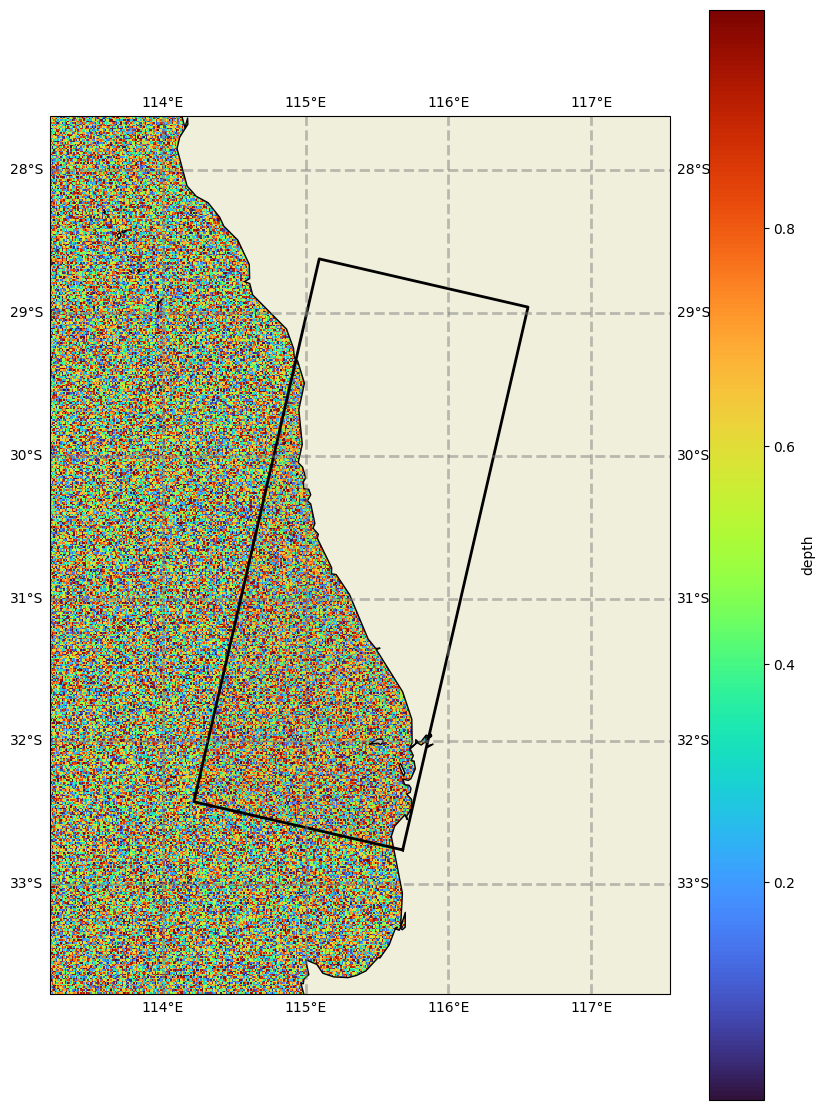

In [21]:
# Create dummy data
bathy_source = nc_bathy()

# Intantiate a swan data object using this dummy data as input
bathy = SwanDataGrid(
        id="bottom", dataset=DatasetXarray(uri=bathy_source), z1="depth", var="BOTTOM", latname="lat", lonname="lon"
    )

# Plot the full dataset
bathy.plot(param='depth', fscale=10, model_grid=datagrid)


In [22]:
# If we run the bathy get method, this will write the data in swan format to the stage directory ready for ingestion into the model. 
# At the moment, this is the full dataset, but we will look at subsetting options later
# Note that running this method retuns the required control file commands to read the data
# from the control file

bathy.get('./')

INFO:rompy.swan.data:	Writing bottom to ./bottom.grd
INFO:rompy.swan.data:Writing SWAN ASCII file: ./bottom.grd


"INPGRID BOTTOM REG 113.21844490282216 -33.76 0.0 433 613 0.010000000000005116 0.00999999999999801 EXC -99.0\nREADINP BOTTOM 1.0 'bottom.grd' 3 FREE\n"

INFO:rompy.swan.data:	Writing bottom to ./bottom.grd
INFO:rompy.swan.data:Writing SWAN ASCII file: ./bottom.grd


(<Figure size 1000x1707.51 with 2 Axes>, <GeoAxes: xlabel='lon', ylabel='lat'>)

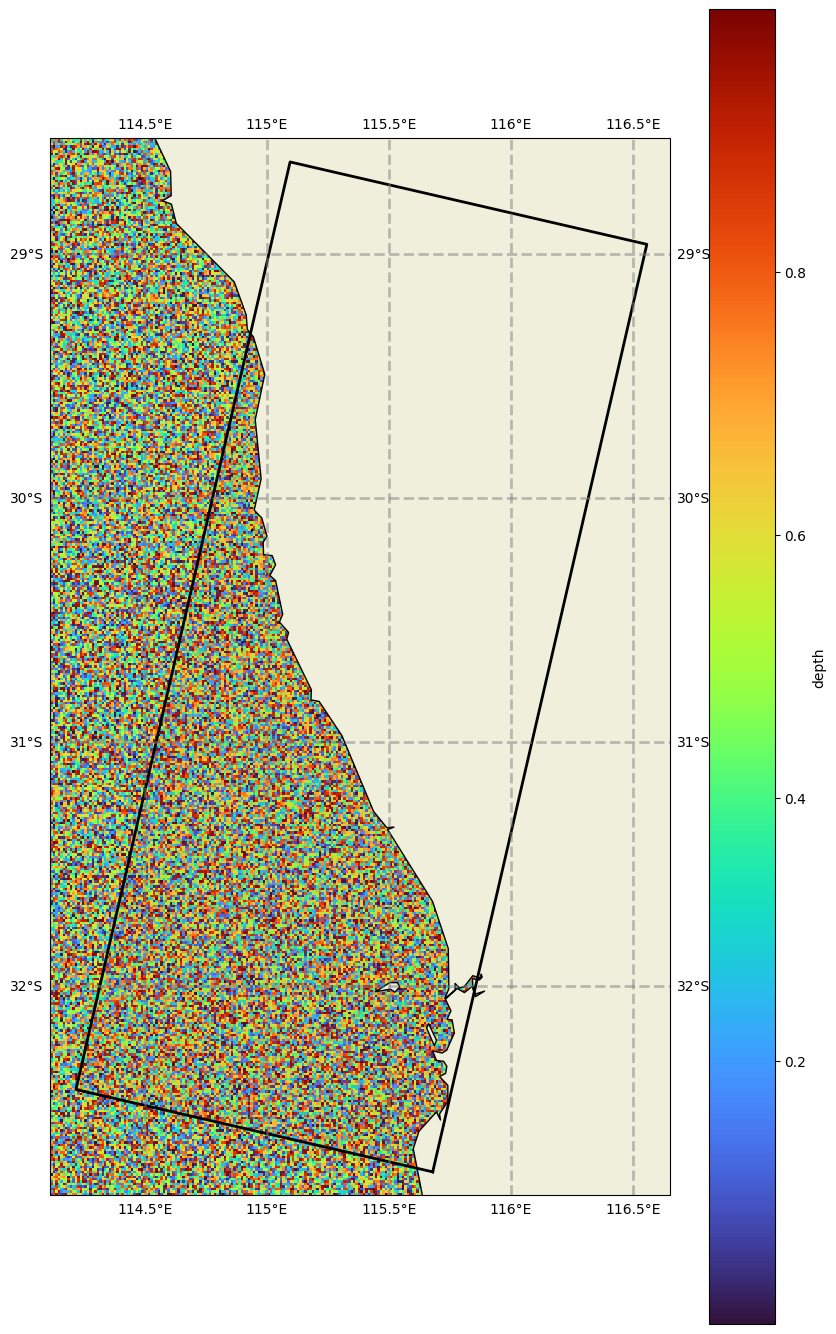

In [23]:
# But instead of just using the data as is, we can use filters to subset it. There are a number of filters available. 
# Here we just demonstrate some hidden convenience functions which use a model grid to subset space. 

bathy._filter_grid(datagrid)
bathy.get('./')
bathy.plot(param='depth', fscale=10, model_grid=datagrid)

In [24]:

# This has now extracted only what it needs based on the grid extents. 
# This is what is done internally in the wrapper (in addition to a analogous time filtering function) allowing us to use lazy grids without doing any pre-filtering, 
# and have the wrapper use only what it needs

In [25]:
# Wind data works the same way. Note the control file input commands are different as it now applied to wind data
wind_source = nc_data_source()
wind = SwanDataGrid(id="wind", var="WIND", dataset=DatasetXarray(uri=wind_source), z1="u", z2="v")
wind.get('./')

INFO:rompy.swan.data:	Writing wind to ./wind.grd


"INPGRID WIND REG 113.21844490282216 -33.76 0.0 433 613 0.010000000000005116 0.00999999999999801 NONSTATION 20200221.000000 24.0 HR\nREADINP WIND 1 'wind.grd' 3 0 1 0 FREE\n"

In [26]:
# The boundary object work in a similar way but is a little more complex as it must determine points around the boundary of the model domain.
# First lets have a look at the boundary object
DataBoundary??

Object `DataBoundary` not found.


In [27]:
# Here we use a test boundary dataset

# Instantiate the boundary object
bnd = DataBoundary(id='bnd', dataset=DatasetXarray(uri="../tests/data/aus-20230101.nc"), latname='lat', lonname='lon', time='time', tolerance=0.1, sel_method='idw')

# plot the unfiltered data locations
bnd.plot(model_grid=grid)
#bnd.ds

NameError: name 'DataBoundary' is not defined

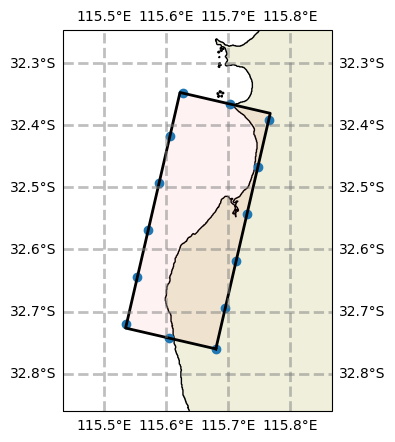

In [ ]:
# Now we can filter the boundary data to the model grid. Here we just use a convenience function to plot the results of this effort 
# TODO - a bit more exlanation needed here

bnd.plot_boundary(grid, fscale=7)

In [ ]:
# Putting these together we can create a swan forcing object When used in a model run, this object will loop over all the data source, filter in time and space to match the model run, 
# write the data to the scratch space, and produce the required control file inputs for swan
forcing = ForcingData(wind=wind, bottom=bathy, boundary=bnd)
forcing.get??

Signature: forcing.get(grid, runtime)
Docstring: <no docstring>
Source:   
    def get(self, grid, runtime):
        forcing = []
        boundary = []
        for source in self:
            if source[1]:
                logger.info(f"\t Processing {source[0]} forcing")
                source[1]._filter_grid(grid)
                source[1]._filter_time(runtime.period)
                if source[0] == "boundary":
                    boundary.append(source[1].get(runtime.staging_dir, grid))
                else:
                    forcing.append(source[1].get(runtime.staging_dir, grid))
        return dict(forcing="\n".join(forcing), boundary="\n".join(boundary))
File:      /source/rompy/rompy/swan/config.py
Type:      method

In [ ]:
# Next, lets look at the physics object. At the moment, this is very simple and only 
# templates friction in line with the old rompy, but this is now very easy to 
# extend to other physics options
SwanPhysics??

Init signature: SwanPhysics(*, friction: str = 'MAD', friction_coeff: float = 0.1) -> None
Source:        
class SwanPhysics(RompyBaseModel):
    """Container class represting configuraable SWAN physics options"""

    friction: str = Field(
        default="MAD", description="The type of friction, either 'MAD' or 'TODO'."
    )
    friction_coeff: float = Field(
        default=0.1,
        description="The coefficient of friction for the given surface and object.",
    )

    @validator("friction")
    def validate_friction(cls, v):
        if v not in ["MAD", "OTHER", "ANDANOTHER"]:
            raise ValueError(
                "friction must be one of MAD, OTHER or ANDANOTHER"
            )  # TODO Raf to add actual friction options
        return v

    @validator("friction_coeff")
    def validate_friction_coeff(cls, v):
        # TODO Raf to add sensible friction coeff range
        if float(v) > 1:
            raise ValueError("friction_coeff must be less than 1")
        if fl

In [ ]:
# Just as a demonstration of a custom validation error, lets try to instantiate a physics object with an invalid friction option
try:
    physics = SwanPhysics(friction='INVALID')
except ValueError as e:
    logger.warning(e)

friction
  friction must be one of MAD, OTHER or ANDANOTHER (type=value_error)


In [ ]:
# Now lets instantiate a valid physics object
physics = SwanPhysics()

# And render its cmd file method
print(physics.cmd)

GEN3 WESTH 0.000075 0.00175
BREAKING
FRICTION MAD 0.1

TRIADS

PROP BSBT
NUM ACCUR 0.02 0.02 0.02 95 NONSTAT 20



In [ ]:
# Finally, the outputs object is used to define the outputs of the model run.
# These specify grid variables and spectral locations to be outputted. 
# They also define a period for output, which defaults to the full model run
Outputs??

Init signature:
Outputs(
    *,
    grid: rompy.swan.config.GridOutput = GridOutput(period=None, variables=['DEPTH', 'UBOT', 'HSIGN', 'HSWELL', 'DIR', 'TPS', 'TM01', 'WIND']),
    spec: rompy.swan.config.SpecOutput = SpecOutput(period=None, locations=OutputLocs
),
) -> None
Source:        
class Outputs(RompyBaseModel):
    """Outputs for SWAN"""

    grid: GridOutput = GridOutput()
    spec: SpecOutput = SpecOutput()
    _datefmt: str = "%Y%m%d.%H%M%S"

    @property
    def cmd(self):
        out_intvl = "1.0 HR"  # Hardcoded for now, need to get from time object too TODO
        ret = "OUTPUT OPTIONS BLOCK 8\n"
        ret += f"BLOCK 'COMPGRID' HEADER 'outputs/swan_out.nc' LAYOUT 1 {' '.join(self.grid.variables)} OUT {self.grid.period.start.strftime(self._datefmt)} {out_intvl}\n"
        ret += "\n"
        if self.spec.locations:
            ret += f"POINTs 'pts' FILE 'out.loc'\n"
        ret += f"SPECout 'pts' SPEC2D ABS 'outputs/spec_out.nc' OUTPUT {self.spec.period.start.strftim

In [ ]:
# TODO fix below
#outputs = Outputs(spec=SpecOutput(locations=[[115.68, -32.76]]), period=TimeRange(start=datetime(2020, 2, 21), end=datetime(2020, 2, 22)))

# Instantiate default model output
outputs = Outputs()
outputs

Outputs(grid=GridOutput(period=None, variables=['DEPTH', 'UBOT', 'HSIGN', 'HSWELL', 'DIR', 'TPS', 'TM01', 'WIND']), spec=SpecOutput(period=None, locations=OutputLocs
))

In [ ]:
# Lets now put those components into a swan config object and instantiate a model run

run = ModelRun(
        run_id="test_swantemplate",
        period=TimeRange(start=datetime(2020, 2, 21, 4), end=datetime(2020, 2, 24, 4)),
        output_dir="simulations",
        config=SwanConfig(
            grid=grid,
            physics=physics,
            forcing=forcing,
            outputs=outputs,
        )
    )

(<Figure size 1000x706.373 with 1 Axes>, <GeoAxes: >)

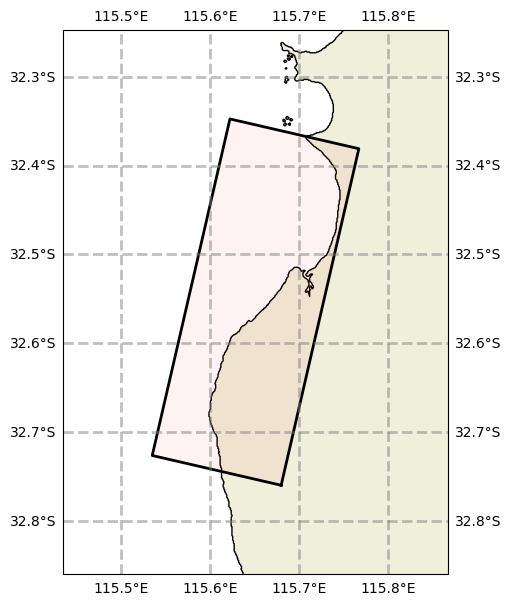

In [ ]:
# This grid object is still accessible as before, but the path has changed slightly
run.config.grid.plot()

In [ ]:
run.config.forcing.get(grid=run.config.grid, runtime=run)

INFO:rompy.swan.config:	 Processing bottom forcing
INFO:rompy.swan.data:	Writing bottom to simulations/test_swantemplate/bottom.grd
INFO:rompy.swan.data:Writing SWAN ASCII file: simulations/test_swantemplate/bottom.grd
INFO:rompy.swan.config:	 Processing wind forcing
INFO:rompy.swan.data:	Writing wind to simulations/test_swantemplate/wind.grd
INFO:rompy.swan.config:	 Processing boundary forcing


ValueError: Empty dataset after applying filter Filter(sort={}, subset={}, crop={'time': slice(datetime.datetime(2020, 2, 21, 4, 0), datetime.datetime(2020, 2, 24, 4, 0), None)}, timenorm={}, rename={}, derived={})

In [ ]:
run.config.outputs.spec.locations

OutputLocs

In [ ]:
run()

INFO:rompy.core.model:
INFO:rompy.core.model:-----------------------------------------------------
INFO:rompy.core.model:Model settings:
INFO:rompy.core.model:period: self.period
output_dir: self.output_dir
config: grid: SwanGrid: REG, 390x150
spectral_resolution: fmin=0.0464 fmax=1.0 nfreqs=31 ndirs=36
forcing: bottom=SwanDataGrid(id='bottom', dataset=DatasetXarray(model_type='xarray', uri='simulations/test_swantemplate/datasets/bathy.nc', engine=None, kwargs={}), filter=Filter(sort={}, subset={}, crop={'lon': slice(115.43481886034701, 115.86750596013977, None), 'lat': slice(-32.86, -32.247452337701304, None), 'time': slice(datetime.datetime(2020, 2, 21, 4, 0), datetime.datetime(2020, 2, 24, 4, 0), None)}, timenorm={}, rename={}, derived={}), variables=['depth'], latname='lat', lonname='lon', timename='time', z1='depth', z2=None, var='BOTTOM') wind=SwanDataGrid(id='wind', dataset=DatasetXarray(model_type='xarray', uri='simulations/test_swantemplate/datasets/wind_inputs.nc', engine=Non

ValueError: Empty dataset after applying filter Filter(sort={}, subset={}, crop={'time': slice(datetime.datetime(2020, 2, 21, 4, 0), datetime.datetime(2020, 2, 24, 4, 0), None)}, timenorm={}, rename={}, derived={})

In [ ]:
run.config.forcing.bottom.path

AttributeError: 'SwanDataGrid' object has no attribute 'path'

In [ ]:
run.dict()

{'run_id': 'test_swantemplate',
 'period': {'start': datetime.datetime(2020, 2, 21, 4, 0),
  'end': datetime.datetime(2020, 2, 24, 4, 0),
  'duration': datetime.timedelta(days=3),
  'interval': datetime.timedelta(seconds=3600),
  'include_end': True},
 'output_dir': 'simulations',
 'config': {'model_type': 'swan',
  'template': '/source/rompy/rompy/templates/swan',
  'checkout': 'main',
  'grid': {'x': array([[115.68      , 115.68022495, 115.6804499 , ..., 115.76705606,
           115.76728101, 115.76750596],
          [115.67902563, 115.67925058, 115.67947553, ..., 115.76608169,
           115.76630664, 115.76653159],
          [115.67805126, 115.67827621, 115.67850116, ..., 115.76510732,
           115.76533227, 115.76555722],
          ...,
          [115.5367676 , 115.53699255, 115.5372175 , ..., 115.62382366,
           115.62404861, 115.62427356],
          [115.53579323, 115.53601818, 115.53624313, ..., 115.62284929,
           115.62307424, 115.62329919],
          [115.5348188

# Command line interface


In [ ]:
# Another advantage of using a declaritive model is that configuration becomes much easier to manage. 
# We have steped through each object separately, but the whole model run can be described with simple 
# arguments. To illustrate this, lets load a simple configuration file to describes the full model run above. 

!cat demo.yml

# Note that this is config fully replicates the config deomonstrated in the demo notebook,
# however it requireds the datasets created in that notebook to work. 

run_id: test_swantemplate 
period:
  start: 20200221T04
  # end: 20200224T04
  duration: 3d
  interval: 1h
output_dir: simulations
config:
  model_type: swan
  grid:
    x0: 115.68
    y0: -32.76
    rot: 77.0
    dx: 0.001
    dy: 0.001
    nx: 390
    ny: 150
    gridtype: REG
  spectral_resolution:
    fmin: 0.0464
    fmax: 1.0
    nfreqs: 31
    ndirs: 36
  forcing:
    wind:
      model_type: swan
      id: wind 
      var: WIND 
      dataset: 
        uri: simulations/test_swantemplate/datasets/wind_inputs.nc
        model_type: xarray
      z1: u
      z2: v
      latname: lat
      lonname: lon
    bottom: 
      id: bottom
      var: BOTTOM
      dataset: 
        uri: simulations/test_swantemplate/datasets/bathy.nc
        model_type: xarray
      z1: depth
      latname: lat
      lonname: lon
  physics': 
    fr

In [ ]:
# initantiating a model run using this config
import yaml
config = yaml.load(open('demo.yml', 'r'), Loader=yaml.FullLoader)

# This is a little hacky - need to fix this
configObs = SwanConfig(**config.pop('config'))
run = ModelRun(**config, config=configObs)

# and then calling as before
run()

INFO:rompy.core.model:
INFO:rompy.core.model:-----------------------------------------------------
INFO:rompy.core.model:Model settings:
INFO:rompy.core.model:period: self.period
output_dir: self.output_dir
config: grid: SwanGrid: REG, 390x150
spectral_resolution: fmin=0.0464 fmax=1.0 nfreqs=31 ndirs=36
forcing: bottom=SwanDataGrid(id='bottom', dataset=DatasetXarray(model_type='xarray', uri='simulations/test_swantemplate/datasets/bathy.nc', engine=None, kwargs={}), filter=Filter(sort={}, subset={}, crop={}, timenorm={}, rename={}, derived={}), variables=['depth'], latname='lat', lonname='lon', timename='time', z1='depth', z2=None, var='BOTTOM') wind=SwanDataGrid(id='wind', dataset=DatasetXarray(model_type='xarray', uri='simulations/test_swantemplate/datasets/wind_inputs.nc', engine=None, kwargs={}), filter=Filter(sort={}, subset={}, crop={}, timenorm={}, rename={}, derived={}), variables=['u', 'v'], latname='lat', lonname='lon', timename='time', z1='u', z2='v', var='WIND') current=None

FileNotFoundError: [Errno 2] No such file or directory: '/source/rompy/notebooks/simulations/test_swantemplate/datasets/bathy.nc'

In [ ]:
# There is also a command line interface to run a defined model configurations

!rompy --help

Usage: rompy [OPTIONS] {base|swan} CONFIG

  Run model Usage: rompy <model> config.yml Args:     model(str): model type
  config(str): yaml config file

Options:
  -k, --kwargs TEXT  additional key value pairs in the format key:value
  --help             Show this message and exit.


In [ ]:
!rompy swan demo.yml

INFO:rompy.core.model:
INFO:rompy.core.model:-----------------------------------------------------
INFO:rompy.core.model:Model settings:
INFO:rompy.core.model:period: self.period
output_dir: self.output_dir
config: model_type='base' template='/source/rompy/rompy/templates/base' checkout='main' config=SwanConfig(model_type='swan', template='/source/rompy/rompy/templates/swan', checkout='main', grid=SwanGrid: REG, 390x150, spectral_resolution=SwanSpectrum(fmin=0.0464, fmax=1.0, nfreqs=31, ndirs=36), forcing=ForcingData(bottom=SwanDataGrid(id='bottom', dataset=DatasetXarray(model_type='xarray', uri='simulations/test_swantemplate/datasets/bathy.nc', engine=None, kwargs={}), filter=Filter(sort={}, subset={}, crop={}, timenorm={}, rename={}, derived={}), variables=['depth'], latname='lat', lonname='lon', timename='time', z1='depth', z2=None, var='BOTTOM'), wind=SwanDataGrid(id='wind', dataset=DatasetXarray(model_type='xarray', uri='simulations/test_swantemplate/datasets/wind_inputs.nc', engi